In [ ]:
import json

ideas_file = 'sample_ideas/agentic_ai_for_idea_generation_ideas.json'

with open(ideas_file, 'r') as f:
    ideas_data = json.load(f)

for ideas in ideas_data['ideas']:
    for idea, items in ideas.items():
        print(idea)
        for item, i in items.items():
            print(f"- {item}")

In [187]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
# from langchain.prompts import ChatPromptTemplate

from typing import Literal
from dotenv import load_dotenv
import json
import os 

load_dotenv()



True

In [188]:

llm = ChatOpenAI(
    temperature=0,  # Set the temperature for the model's responses
    model_name="gpt-5-nano",  # Specify the model name
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

In [ ]:
## Testing LLM Call

# 
# messages = [
#     SystemMessage(content="You are a helpful assistant that speaks like a pirate."),
#     HumanMessage(content="Tell me about Python programming.")
# ]
# response = llm.invoke(messages)
# print(response.content)


## Retrieve Paper with SemanticScholar

In [189]:
import requests


class getReferencePaper():
    def __init__(self):
        self.api_key = os.getenv("SEMANTIC_SCHOLAR_API_KEY")


    def query_search(self, query):
        url="https://api.semanticscholar.org/graph/v1/paper/search/"
        
        query_params = {
            "query": query,
            "fields": "title,citationCount,tldr,url,publicationTypes,publicationDate,openAccessPdf,abstract",
            "year": "2020-2025",
            "limit": 50,
            "sort": "relevance",
            "minCitationCount": 10
        }
        headers = {"x-api-key": self.api_key}
        response = requests.get(url, params=query_params, headers=headers).json()
        
        return response

    def PaperDetails(self, paper_id, fields="title,year,abstract,authors,citationCount,venue,citations,references,tldr"):
        
        url = "https://api.semanticscholar.org/graph/v1/paper/"
        
        paper_data_query_params = {"fields": fields}
        headers = {"x-api-key": self.api_key}
        response = requests.get(
            url = url + paper_id, params=paper_data_query_params, headers=headers
        )
        
        return response.json()
    
    @staticmethod
    def prepare_papers_for_llm(list_of_papers):
        unique_papers = {}

        for query_string, query_data in list_of_papers.items():
            for paper in query_data.get('data', []):
                paper_id = paper.get('paperId')
                if paper_id and paper_id not in unique_papers:  # Skips if paper_id is None
                    paper_str = f"""Paper ID: {paper_id}
                                    Title: {paper.get('title')}
                                    Abstract: {paper.get('abstract')}
                                """
                    unique_papers[paper_id] = paper_str
                    
        paper_list = list(unique_papers.values())
                
        papers_for_llm = "\n\n---\n\n".join(paper_list)
        return papers_for_llm

 
# query = 'Computing Machinery and Intelligence'

# search_paper = getReferencePaper()
# search_paper_response = search_paper.query_search(query)




## Graph

In [87]:
from typing import Optional
from pydantic import BaseModel, Field

class DirectAnswer(BaseModel):
    """
    Intent Agent Answer
    """
    direct_answer: str = Field(default="", description="contains the general conversation answer to the user prompt")


# Define the WriterAnswer model for story or general answer responses
class WriterAnswer(BaseModel):
    """
    Used to answer with a story or general answer
    """
    story: Optional[str] = Field(default="", description="contains exclusively the story, no introduction or conclusion")
    general_answer: Optional[str] = Field(default="", description="contains the general answer if no story is provided")

    def to_list(self) -> list:
        return [{
            "story": self.story,
            "general_answer": self.general_answer
        }]
    
# Define the CriticAnswer model for story feedback responses
class CriticAnswer(BaseModel):
    """
    Story Critic Agent Answer
    """
    feedback: str = Field(default="", description="contains your feedback on the story, the reasons why the story is not compliant")
    story_ok: bool = Field(default="", description="True if you validated the story is correct, False otherwise")

    def to_list(self):
        return [{
            "feedback": self.feedback,
            "story_ok": self.story_ok,
        }]

### Agent 1: Idea Parser

In [88]:
from typing import Optional, List, Dict
from pydantic import BaseModel, Field, field_validator


class IdeaParser(BaseModel):
    """
    Agent 1: Parse Idea from user input into structured format.
    1. Extract ideas from the user's input.
    """
    research_question: str = Field(
        description="The main research question in one conscise sentence"
    )
    
    problem_domain: str = Field(
        description="The specific problem domain or area of interest related to the research question. (e.g., natural language processing, computer vision, etc.)"
    )
    
    methodology_keywords: List[str] = Field(
        description="A list of technical keywords mentioned in the methods"
    )
    
    key_concepts: List[str] = Field(
        description="A list of key concepts or theories relevant to the research question and problem domain."
    )
    
    existing_methods: List[str] = Field(
        description="A list of existing methods or approaches mentioned in the user's input that are relevant to the research question and problem domain."
    )
    
    claimed_novelty: List[str] = Field(
        description="A list of claimed novel aspects or contributions inferred from the user's input."
    )
    
    
    
    @field_validator('key_concepts')
    @classmethod
    def validate_key_concepts_counts(cls, v):
        """Ensure that there are a reasonable number of key concepts extracted"""
        if len(v) < 3 or len(v) > 15:
            raise ValueError('At least 3 and at most 15 key concepts are required.')
        return v

    def to_dict(self) -> Dict:
        return self.model_dump()
    
    def to_summary(self) -> str:
        return f"""Research Question: {self.research_question}\n
                    Problem Domain: {self.problem_domain}\n
                    Key Concepts: {', '.join(self.key_concepts)}\n
                    Claimed Novelty: {', '.join(self.claimed_novelty)}"""

In [89]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

idea_parser_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a research analysis assistant that has a deep understanding of extracting structured information from research proposals.

            INPUT:
            You will receive a research idea description with these fields:
            - Problem: The research problem being addressed
            - Existing Methods: Current approaches and their limitations
            - Motivation: Why this research is needed
            - Proposed Method: The new approach being proposed
            - Experiment Plan: How the approach will be evaluated

            YOUR TASK:
            Extract and structure the key information needed for finding similar work.

            OUTPUT REQUIREMENTS:
            Return ONLY valid JSON with NO additional text, markdown formatting, or code blocks.
            Do not include ```json or ``` markers.
            Your entire response must be parseable by JSON.parse().

            CRITICAL: Be precise and specific in extraction. Extract actual technical terms, not generic descriptions.

            OUTPUT SCHEMA:
            {{
            "research_question": "string - The main research question in one concise sentence",
            "problem_domain": "string - The specific research area/field (e.g., 'natural language processing', 'computer vision')",
            "methodology_keywords": [
                "string - Specific technical methods mentioned (e.g., 'reinforcement learning', 'transformer architecture')"
            ],
            "key_concepts": [
                "string - Core concepts and techniques (e.g., 'prompt optimization', 'context window management')"
            ],
            "existing_methods_mentioned": [
                "string - Baseline methods or prior work explicitly mentioned"
            ],
            "claimed_novelty_aspects": [
                "string - What the proposal claims is novel (extract from Motivation and Proposed Method)"
            ]
            }}

            EXTRACTION RULES:
            1. Be specific: Extract "transformer architecture" not "neural network"
            2. Preserve technical terms exactly as written
            3. For methodology_keywords: Include only actionable technical terms
            4. For key_concepts: Include 5-8 most important concepts
            5. For claimed_novelty_aspects: Extract 2-4 specific novel claims
            6. If a field has no relevant information, use empty array [] or empty string ""

            RESEARCH IDEA:
            {research_idea}

            OUTPUT (valid JSON only):
            """,
        ),
        # MessagesPlaceholder(variable_name="messages"),  # Placeholder for dynamic messages
    ])


# Create the writer agent by binding the prompt template and language model
idea_parser_agent = idea_parser_prompt |  llm.with_structured_output(IdeaParser)



In [90]:
def call_idea_parser(state: MessagesState):
    user_message = state["messages"][-1]  # HumanMessage
    
    # Invoke the agent chain
    response = idea_parser_agent.invoke({
        "research_idea": user_message.content
    })
    # response is now an IdeaParser object
    
    return {"messages": [AIMessage(content=json.dumps(response.to_dict(), indent=2))]}


### Agent 2: Literature Retrieval

In [91]:
class QueryGenerator(BaseModel):
    """
    Agent 2: Generate Search Queries from parsed research idea.
    1. Create effective search queries to find related work.
    """
    query_string: str = Field(
        description="Search query to be passed to the API"
    )
    
    rationale: str = Field(
        description="Rationale for why this query will find relevant papers"
    )
    
    priority_concept: str = Field(
    description="The most important concept to focus on in the search"
    )
    
    @field_validator('query_string')
    @classmethod
    def validate_query_string_length(cls, v):
        """Ensure that the query is not too long"""
        if len(v.split()) > 8:
            raise ValueError('Query string must be less than 8 words.')
        return v

    def to_dict(self) -> Dict:
        return self.model_dump()
    
class QueryGeneratorOutput(BaseModel):
    """Multiple search queries"""
    queries: List[QueryGenerator] = Field(
        description="List of 5 diverse search queries"
    )
    
    def to_dict(self) -> Dict:
        return {
            "queries": [q.to_dict() for q in self.queries]
        }
    




In [ ]:

query_generator_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced professor with an established search query strategy skill for academic literature databases.

            CONTEXT:
            You have a parsed research idea and need to generate optimal search queries for Semantic Scholar API.
            Your queries will retrieve papers to assess the novelty of the proposed research.

            PARSED RESEARCH IDEA:
            {parsed_idea_json}


            YOUR TASK:
            Generate 5 (five) diverse search queries that will find the most relevant existing work.


            QUERY OPTIMIZATION RULES:
            1. Keep queries SHORT: 2-6 words maximum for best results
            2. Use technical terms, not natural language
            3. Combine 2-3 concepts maximum per query
            4. NO operators: Don't use "AND", "OR", "-", quotes, or "site:"
            5. Prioritize precision over recall

            OUTPUT REQUIREMENTS:
            Return ONLY valid JSON with NO additional text or formatting.
            Do not include ```json or ``` markers.

            OUTPUT SCHEMA:
            {{
            "queries": [
                {{
                "query_string": "string - The actual search query (2-6 words)",
                "rationale": "string - Why this query will find relevant papers",
                "priority_concepts" : "string - Top 3-5 concepts that should appear in similar papers"
                }}
            ]
            }}

            EXAMPLES OF GOOD QUERIES:
            - "adaptive prompt dialogue coherence"
            - "dynamic context management LLM"
            - "conversational continuity language models"
            - "iterative prompt optimization"

            EXAMPLES OF BAD QUERIES:
            - "papers about improving language model coherence" (too natural language)
            - "dynamic AND adaptive OR iterative -static" (operators not supported)
            - "comprehensive survey of prompt engineering techniques" (too long/broad)

            OUTPUT (valid JSON only):""",
        ),
        # MessagesPlaceholder(variable_name="messages"),  # Placeholder for dynamic messages
    ])


query_generator_agent = query_generator_prompt |  llm.with_structured_output(QueryGeneratorOutput)



In [93]:
def call_query_generator(state: MessagesState):
    last_message = state["messages"][-1]  # HumanMessage
    
    # Invoke the agent chain
    response = query_generator_agent.invoke({
        "parsed_idea_json":last_message.content #json.dumps(json.loads(last_message.content))
    })
    # response is now an IdeaParser object
    
    return {"messages": [AIMessage(content=json.dumps(response.to_dict(), indent=2))]}


#### AGENT 3 : search paper using semantic scholar api

In [ ]:
def call_paper_search(state: MessagesState):
    last_message = state["messages"][-1]  # LastMessage
    queries_json = json.loads(last_message.content)
    all_search_results = {}
    
    search_paper = getReferencePaper()

    
    for search_query in queries_json['queries']:
        query_string = search_query['query_string']
        search_results = search_paper.query_search(query_string)
        all_search_results[query_string] = search_results
    
    return {"messages": [AIMessage(content=json.dumps(all_search_results, indent=2))]}

### Agent 4 : Score

In [128]:
class PaperAnalyzer(BaseModel):
    """
    Agent 2: Generate Search Queries from parsed research idea.
    1. Create effective search queries to find related work.
    """
    paper_id: str = Field(
        description="semantic scholar paper ID to be analyzed"
    )
    
    title: str = Field(
        description="Title of the paper to be analyzed"
    )
    
    overlap_score: float = Field(
        description="float 0.0-1.0 - overlap similarity with proposed idea"
    )
    
    methodology_overlap: float = Field(
        description="score 0 - 1. Methodology overlap with the proposed idea (inferring from abstract and title)"
    )
    
    problem_overlap: float = Field(
        description="score 0 - 1. Problem overlap with the proposed idea (inferring from abstract and title)"
    )
    
    domain_overlap: float = Field(
        description="score 0 - 1. Domain overlap with the proposed idea (inferring from abstract and title)"
    )   
    key_overlaps: List[str] = Field(
        description="Specific overlapping aspects"
    )
    
    key_differences: List[str] = Field(
        description="How proposed idea differs"
    )

    def to_dict(self) -> Dict:
        return self.model_dump()
    
class PaperAnalyzerOutput(BaseModel):
    """Multiple search queries"""
    queries: List[PaperAnalyzer] = Field(
        description="List of all analyzed papers"
    )
    
    def to_dict(self) -> Dict:
        return {
            "papers": [q.to_dict() for q in self.queries]
        }
    
    
    

In [163]:


prior_work_analysis_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experience researcher with years of expertise in academic literature review and analysis.

                PROPOSED RESEARCH IDEA:
                {research_idea}
                
                LIST OF RETRIEVED PAPERS:
                {paper_list}
                
                YOUR TASK:
                For each paper, assess the degree of overlap with the proposed research idea.
                
                ANALYSIS CRITERIA:
                Methodology overlap: Do they use similar approaches?
                Problem overlap: Do they address the same problem?
                Domain overlap: Same application area?
                Overall score: The average of the three overlap scores.
                
                OUTPUT REQUIREMENTS:
                Return ONLY valid JSON with NO additional text.
                Do not include ```json or ``` markers.
                
                OUTPUT SCHEMA:
                {{
                "paper_analyses": [
                   {{
                      "paper_id": "string - Semantic Scholar paper ID",
                      "title": "string",
                      "overlap_score": "float 0.0-1.0 - Overall similarity",
                      "methodology_overlap": "float 0.0-1.0",
                      "problem_overlap": "float 0.0-1.0", 
                      "domain_overlap": "float 0.0-1.0",
                      "key_overlaps": [
                        "string - Specific overlapping aspects"
                      ],
                      "key_differences": [
                        "string - How proposed idea differs"
                      ]
                    }}
                  ]
                }}
                
                SCORING GUIDELINES:
                overlap_score 0.8-1.0: Nearly identical approach
                overlap_score 0.6-0.8: High similarity, incremental difference
                overlap_score 0.4-0.6: Moderate similarity, related work
                overlap_score 0.2-0.4: Tangentially related
                overlap_score 0.0-0.2: Different approach, same domain
                
                Be precise and evidence-based. Cite specific aspects from paper titles/abstracts.
                
                OUTPUT (valid JSON only):
                
            """,
        ),
        # MessagesPlaceholder(variable_name="messages"),  # Placeholder for dynamic messages
    ])

prior_work_analysis_agent = prior_work_analysis_prompt |  llm.with_structured_output(PaperAnalyzerOutput)

In [150]:
def call_prior_work_analysis(state: MessagesState):
    last_message = state["messages"][-1]  # HumanMessage
    initial_user_input = state["messages"][0]  # Research idea
    
    
    list_of_papers = getReferencePaper.prepare_papers_for_llm(
        json.loads(last_message.content)
    )
    
    # Invoke the agent chain
    response = prior_work_analysis_agent.invoke({
        "research_idea":initial_user_input.content, #json.dumps(json.loads(last_message.content)),
        "paper_list": list_of_papers
    })
    # response is now an IdeaParser object
    
    return {"messages": [AIMessage(content=json.dumps(response.to_dict(), indent=2))]}


### Experiments

In [164]:
workflow = StateGraph(MessagesState)

workflow.add_node("idea_parser", call_idea_parser)
workflow.add_node("search_query", call_query_generator)
workflow.add_node("search_paper", call_paper_search)
workflow.add_node("prior_work_analysis", call_prior_work_analysis)

workflow.add_edge(START, "idea_parser")
workflow.add_edge("idea_parser", "search_query")
workflow.add_edge("search_query", "search_paper")
workflow.add_edge("search_paper", "prior_work_analysis")
workflow.add_edge("prior_work_analysis", END)

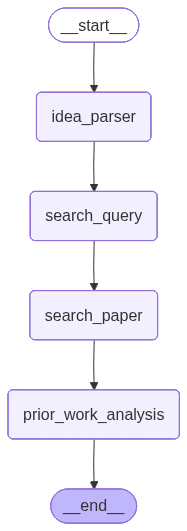

In [165]:
from IPython.display import Image, display

graph = workflow.compile()
# graph.get_graph().draw_mermaid_png(output_file_path='story.png')
display(Image(graph.get_graph().draw_mermaid_png()))

In [166]:
graph = workflow.compile()
graph.get_graph().draw_mermaid_png(output_file_path='story.png')

result_llm = graph.invoke(
    {
        "messages": [
            (
                "user",
                """Dynamic Prompt Adaptation:
                Problem: Large Language Models (LLMs) often struggle with maintaining coherence over extended interactions or creative tasks, leading to thematic inconsistencies and reduced reader engagement.
                Existing Methods: Current methods often use fixed prompts or few-shot examples, which may not adapt to the evolving context of a conversation or creative narrative. Techniques such as Chain-of-Thought prompting are utilized, but they do not inherently address continuity and adaptability across interactions.
                Motivation: Human creative writing often involves iterative dialogue and adaptation to the flow of discussion. The style and context of interactions can shift dynamically based on prior exchanges. Dynamic adaptation mirrors how authors and conversationalists adjust based on audience feedback and shifting themes.
                Proposed Method: We propose Dynamic Prompt Adaptation, involving three phases: (1) Contextual Analysis - Analyze previous outputs and user prompts to extract key themes and tonal shifts, applying a prompting structure like 'Reflect on the previous topic of [theme] and build on it.' (2) Adaptive Prompt Generation - Using insights from the analysis, generate updated prompts that introduce new elements or clarify past responses, e.g., 'Continuing from your last thought on [theme], can you expand on how this might be represented in [new context]?' (3) Iterative Context Update - As the dialogue progresses, generate a synthesis of all prior interactions to maintain thematic coherence, prompting with 'Summarize the key points discussed so far to keep track of our narrative.'
                Experiment Plan: Test against static prompting strategies by evaluating engagement scores, coherence assessments, and user satisfaction in storytelling scenarios using standard text generation metrics such as BLEU and ROUGE. Incorporate user feedback on naturalness and adaptability during the interaction. Datasets could include the 'Story Cloze Test' dataset and user-generated dialogue interactions scraped from platforms like Reddit to assess conversational engagement."""
            )
        ]
    },
    debug=True
)

[values] {'messages': [HumanMessage(content="Dynamic Prompt Adaptation:\n                Problem: Large Language Models (LLMs) often struggle with maintaining coherence over extended interactions or creative tasks, leading to thematic inconsistencies and reduced reader engagement.\n                Existing Methods: Current methods often use fixed prompts or few-shot examples, which may not adapt to the evolving context of a conversation or creative narrative. Techniques such as Chain-of-Thought prompting are utilized, but they do not inherently address continuity and adaptability across interactions.\n                Motivation: Human creative writing often involves iterative dialogue and adaptation to the flow of discussion. The style and context of interactions can shift dynamically based on prior exchanges. Dynamic adaptation mirrors how authors and conversationalists adjust based on audience feedback and shifting themes.\n                Proposed Method: We propose Dynamic Prompt A

In [133]:
list_of_papers = json.loads(result_llm["messages"][-1].content)

In [191]:
import json
import pandas as pd

# Parse the results
result_content = json.loads(result_llm["messages"][-1].content)

# Create DataFrame
papers_df = pd.DataFrame(result_content['papers'])

papers_df[["methodology_overlap","problem_overlap","domain_overlap"]]


## NOTE
## Wrong overlap calculation

### Development Note
## might be interesting to make the output of this papers analysis passed into 
## a GAN-like architecture (So not using overlapping score like the current one)
## where one agent is argumenting why the idea is novel
## and another agent is criticising why the idea is not novel, both based on the prior work
## and then another agent act as a judge to decide which argument is stronger

,methodology_overlap,problem_overlap,domain_overlap
0,0.85,0.85,0.70
1,0.84,0.82,0.78
2,0.83,0.82,0.80
3,0.70,0.70,0.75
4,0.78,0.75,0.76
5,0.72,0.68,0.65
6,0.80,0.80,0.80
7,0.72,0.70,0.70
8,0.66,0.66,0.70
9,0.68,0.70,0.72
